In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import torch.autograd
from torch.autograd import Variable
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding
from collections import deque
from tqdm import tqdm, trange
import random
import sys
import matplotlib.pyplot as plt
import scipy.io

time: 0.00, target: 0.00, current value: 0.00, error: 0.00, control signal: 0.00
time: 0.00, target: 0.01, current value: 0.00, error: 0.01, control signal: 0.00
time: 0.00, target: 0.01, current value: 0.00, error: 0.01, control signal: 0.00
time: 0.00, target: 0.02, current value: 0.01, error: 0.02, control signal: 0.01
time: 0.00, target: 0.03, current value: 0.01, error: 0.02, control signal: 0.01
time: 0.01, target: 0.03, current value: 0.02, error: 0.02, control signal: 0.02
time: 0.01, target: 0.04, current value: 0.03, error: 0.02, control signal: 0.03
time: 0.01, target: 0.04, current value: 0.03, error: 0.02, control signal: 0.03
time: 0.01, target: 0.05, current value: 0.04, error: 0.02, control signal: 0.04
time: 0.01, target: 0.06, current value: 0.04, error: 0.02, control signal: 0.04
time: 0.01, target: 0.06, current value: 0.05, error: 0.02, control signal: 0.05
time: 0.01, target: 0.07, current value: 0.06, error: 0.02, control signal: 0.06
time: 0.01, target: 0.08, cu

time: 3.78, target: -0.98, current value: -0.99, error: 0.01, control signal: -0.99
time: 3.78, target: -0.98, current value: -0.98, error: 0.01, control signal: -0.98
time: 3.78, target: -0.98, current value: -0.98, error: 0.01, control signal: -0.98
time: 3.78, target: -0.98, current value: -0.98, error: 0.01, control signal: -0.98
time: 3.78, target: -0.97, current value: -0.98, error: 0.01, control signal: -0.98
time: 3.79, target: -0.97, current value: -0.98, error: 0.01, control signal: -0.98
time: 3.79, target: -0.97, current value: -0.98, error: 0.01, control signal: -0.98
time: 3.79, target: -0.97, current value: -0.98, error: 0.01, control signal: -0.98
time: 3.79, target: -0.97, current value: -0.98, error: 0.01, control signal: -0.98
time: 3.79, target: -0.97, current value: -0.97, error: 0.01, control signal: -0.97
time: 3.79, target: -0.97, current value: -0.97, error: 0.01, control signal: -0.97
time: 3.79, target: -0.96, current value: -0.97, error: 0.01, control signal

Text(0, 0.5, 'Cumulative Reward')

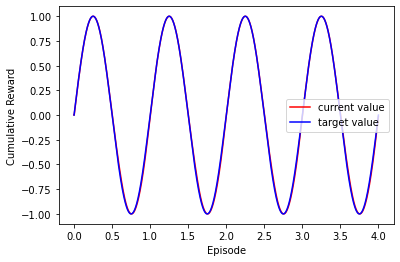

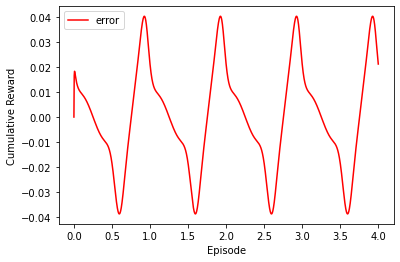

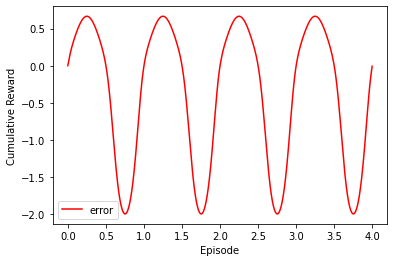

In [16]:
class PID:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd

    def update(self, control_signal, error, error_old, error_old_old):
        derivative = error - error_old
        derivative_2 = error - 2 * error_old + error_old_old
        output = control_signal + self.Ki * error + self.Kp * derivative + self.Kd * derivative_2
        return output

# Example program
pid = PID(Kp=0.12, Ki=0.32, Kd=0.08)
T = 4
dt = 0.001
time_list = np.linspace(0, T, int(T/dt))
target_list = np.sin(time_list * 2 * np.pi)
time = 0.0
current_value = 0.0
error_old = 0.0
error_old_old = 0.0
control_signal = 0.0
current_value_sum = []
error_sum = []
control_signal_sum = []

for target in target_list:
    error = target - current_value
    control_signal_new = pid.update(control_signal, error, error_old, error_old_old)
    current_value_new = current_value / (1 + current_value ** 2) * control_signal_new + control_signal
    print(f"time: {time:.2f}, target: {target:.2f}, current value: {current_value_new:.2f}, error: {error:.2f}, control signal: {current_value_new:.2f}")
    time += dt
    control_signal = control_signal_new
    current_value = current_value_new
    error_old = error
    error_old_old = error_old
    current_value_sum.append(current_value)
    error_sum.append(error)
    control_signal_sum.append(control_signal)

plt.figure()    
plt.plot(time_list, current_value_sum, label = 'current value', color = 'r')
plt.plot(time_list, target_list, label = 'target value', color = 'b')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')

plt.figure()    
plt.plot(time_list, error_sum, label = 'error', color = 'r')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')

plt.figure()    
plt.plot(time_list, control_signal_sum, label = 'error', color = 'r')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')




In [17]:

class Critic_network(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(Critic_network, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, output_size)
        self.relu = nn.ReLU()

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

class Actor_network(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(Actor_network, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, state):
        x = self.fc1(state)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)

        return x

In [18]:
class DDPGagent:
    def __init__(self, env, hidden_size_1=64, hidden_size_2=16, actor_lr=1e-4, critic_lr=1e-3, gamma=0.99, tau=1e-2, max_buffer_size=50000, batch_size = 128):
        self.states_number = env.observation_space.shape[0]
        self.actions_number = env.action_space.shape[0]
        self.action_low = env.action_space.low
        self.action_high = env.action_space.high
        self.gamma = gamma
        self.tau = tau
        self.buffer = deque(maxlen = max_buffer_size)
        self.batch_size = batch_size
        self.actor = Actor_network(self.states_number, hidden_size_1, hidden_size_2, self.actions_number).cuda()
        self.actor_target = Actor_network(self.states_number, hidden_size_1, hidden_size_2, self.actions_number).cuda()
        self.critic = Critic_network(self.states_number + self.actions_number, hidden_size_1, hidden_size_2, self.actions_number).cuda()
        self.critic_target = Critic_network(self.states_number + self.actions_number, hidden_size_1, hidden_size_2, self.actions_number).cuda()

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
    
    def get_action(self, observation):
        observation = torch.tensor(observation).float()
        action = self.actor.forward(observation.cuda())
        action = action.cpu().detach().numpy()
        return action
    
    def noise(self, action, t):
        noise_sample = 0.25 * np.exp(- t / 4000) * np.random.randn(self.actions_number)
        action_noise =  np.clip(action + noise_sample, self.action_low, self.action_high)
        return action_noise
    
    def add_buffer(self, observation, action, reward, observation_new, terminated):
        experience = (observation, action, np.array([reward]), observation_new, terminated)
        self.buffer.append(experience) 
        return len(self.buffer)
    
    def sample(self):
        observation_batch = []
        action_batch = []
        reward_batch = []
        observation_new_batch = []
        terminated_batch = []
        batch = random.sample(self.buffer, self.batch_size)

        for experience in batch:
            observation, action, reward, observation_new, terminated = experience
            observation_batch.append(observation)
            action_batch.append(action)
            reward_batch.append(reward)
            observation_new_batch.append(observation_new)
            terminated_batch.append(terminated)
        return observation_batch, action_batch, reward_batch, observation_new_batch, terminated_batch
    
    def update(self):
        observation, actions, rewards, observation_new, terminated = self.sample()
        observation = torch.FloatTensor(observation)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        observation_new = torch.FloatTensor(observation_new)
       
        state_value_target = self.critic.forward(observation.cuda(), actions.cuda())
        next_actions = self.actor_target.forward(observation_new.cuda())
        next_state_value = self.critic_target.forward(observation_new.cuda(), next_actions.detach())
        state_value_A = rewards.cuda() + self.gamma * next_state_value
        critic_loss = self.critic_criterion(state_value_target, state_value_A)

        acor_loss = -self.critic.forward(observation.cuda(), self.actor.forward(observation.cuda())).mean()

        self.actor_optimizer.zero_grad()
        acor_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau/5 + target_param.data * (1.0 - self.tau/5))
       
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))


In [19]:
class Plant(gym.Env):

    def __init__(self, target, T, dt, alpha = 0.6, beta = 0.4, error_limit = 0.01):
        self.viewer = None
        self.state_limit = np.ones(3) * 10
        self.action_max = np.ones(3) * 1
        self.action_min = np.zeros(3)
        self.observation_space = spaces.Box(low = -self.state_limit, high = self.state_limit, dtype = np.float32)
        self.action_space = spaces.Box(low = -self.action_min, high = self.action_max, dtype = np.float32)
        self.target = target
        self.T = T
        self.dt = dt
        self.alpha = alpha
        self.beta = beta
        self.error_limit = error_limit

        self.time = 0.0
        self.current_value = 0.0
        self.error_old = 0.0
        self.error_old_old = 0.0
        self.control_signal = 0.0
        self.error = self.target[0]
        self.derivative = self.error
        self.derivative_2 = self.error
        self.current_value_sum = []
        self.error_sum =[]

    def step(self, action):
        Kp = action[0] * 0.7
        Ki = action[1] * 0.8
        Kd = action[2] * 0.6
        num = int(self.time/self.dt)
#         print(action,'action')

        control_signal_new = self.control_signal + Ki * self.error + Kp * self.derivative + Kd * self.derivative_2
        control_signal_new = np.clip(control_signal_new, -100, 100)
        current_value_new = self.current_value / (1 + self.current_value ** 2) * control_signal_new + self.control_signal
        # print(f"time: {self.time:.2f}, target: {self.target[num]:.2f}, current value: {current_value_new:.2f}, error: {self.error:.2f}, control signal: {current_value_new:.2f}")
        self.time += self.dt
        self.control_signal = control_signal_new
        self.current_value = current_value_new
        self.error_old = self.error
        self.error_old_old = self.error_old
        self.current_value_sum.append(self.current_value)
        self.error_sum.append(self.error)

        self.error = self.target[num+1] - self.current_value
        self.derivative = self.error - self.error_old
        self.derivative_2 = self.error - 2 * self.error_old + self.error_old_old
        self.state = np.array([self.error, self.derivative, self.derivative_2]) 
        # print(self.state,'self.state')

        if abs(self.error) <= self.error_limit:
            reward_error = 0
        else:
            reward_error = -0.5
        if abs(self.error) <= abs(self.error_old):
            reward_error_speed = 0
        else:
            reward_error_speed = -0.5
        reward = self.alpha * reward_error + self.beta * reward_error_speed
        # print(reward_error,'reward_error',reward_error_speed,'reward_error_speed')

        if self.time >= self.T - self.dt:
            terminated = True
        else:
            terminated = False
        
        truncated = False

        return self.state, reward, terminated, truncated, {}

    def reset(self):
        self.time = 0.0
        self.current_value = 0.0
        self.error_old = 0.0
        self.error_old_old = 0.0
        self.control_signal = 0.0
        self.error = self.target[0]
        self.derivative = self.error
        self.derivative_2 = self.error
        self.current_value_sum = []
        self.error_sum =[]
        self.state = np.array([self.error, self.derivative, self.derivative_2]) 
        
        return self.state

Text(0, 0.5, 'e')

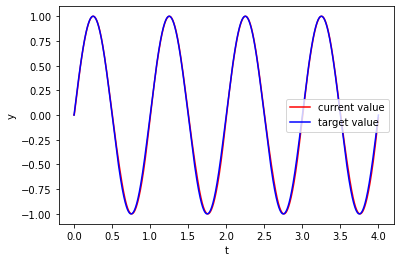

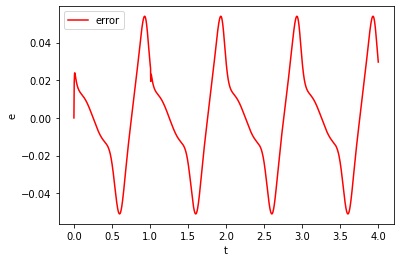

In [32]:
T = 4
dt = 0.001
time_list = np.linspace(0, T, int(T/dt))
target_list = np.sin(time_list * 2 * np.pi)
test = Plant(target = target_list, T = T, dt = dt)

for target in target_list:
    action = np.array([0.1,0.3,0.1])
    state, reward, terminated, truncated, _ = test.step(action)

plt.figure()    
plt.plot(time_list, test.current_value_sum, label = 'current value', color = 'r')
plt.plot(time_list, target_list, label = 'target value', color = 'b')
plt.legend()
plt.xlabel('t')
plt.ylabel('y')

plt.figure()    
plt.plot(time_list, test.error_sum, label = 'error', color = 'r')
plt.legend()
plt.xlabel('t')
plt.ylabel('e')

  0%|          | 0/20 [00:00<?, ?it/s, reward=0, timesteps=127, totalreward=-33.1]  /scratch/15798452/ipykernel_3159665/1851221943.py:61: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /var/tmp/aebruno2/easybuild/build/PyTorch/1.13.1/foss-2021b-CUDA-11.8.0/pytorch-v1.13.1/torch/csrc/utils/tensor_new.cpp:230.)
  observation = torch.FloatTensor(observation)
  5%|▌         | 1/20 [00:31<10:01, 31.63s/it, reward=-.3, timesteps=24, totalreward=-9.9]     

Episode 0:  -1100.1


 10%|█         | 2/20 [01:02<09:24, 31.35s/it, reward=-.5, timesteps=24, totalreward=-10.6]     

Episode 1:  -1270.7


 15%|█▌        | 3/20 [01:34<08:52, 31.30s/it, reward=0, timesteps=24, totalreward=-3.3]    

Episode 2:  -911.6


 20%|██        | 4/20 [02:05<08:18, 31.16s/it, reward=0, timesteps=25, totalreward=-6.1]    

Episode 3:  -958.0


 25%|██▌       | 5/20 [02:42<08:20, 33.34s/it, reward=0, timesteps=23, totalreward=-4.5]        

Episode 4:  -1323.4


 30%|███       | 6/20 [03:18<07:58, 34.17s/it, reward=0, timesteps=24, totalreward=-3.4]    

Episode 5:  -758.0


 35%|███▌      | 7/20 [03:49<07:10, 33.13s/it, reward=-.2, timesteps=24, totalreward=-4.8]  

Episode 6:  -752.0


 40%|████      | 8/20 [04:20<06:29, 32.48s/it, reward=-.2, timesteps=24, totalreward=-4.6]  

Episode 7:  -759.9


 45%|████▌     | 9/20 [04:53<06:00, 32.79s/it, reward=-.2, timesteps=16, totalreward=-3.7]  

Episode 8:  -756.3


 50%|█████     | 10/20 [05:32<05:46, 34.61s/it, reward=0, timesteps=17, totalreward=-3]     

Episode 9:  -746.7


 55%|█████▌    | 11/20 [06:04<05:05, 33.97s/it, reward=-.2, timesteps=24, totalreward=-3.2]  

Episode 10:  -754.1


 60%|██████    | 12/20 [06:36<04:25, 33.13s/it, reward=0, timesteps=22, totalreward=-4.7]    

Episode 11:  -757.7


 65%|██████▌   | 13/20 [07:07<03:48, 32.58s/it, reward=0, timesteps=24, totalreward=-3.2]    

Episode 12:  -761.2


 70%|███████   | 14/20 [07:41<03:17, 32.99s/it, reward=-.2, timesteps=24, totalreward=-4.6]  

Episode 13:  -765.0


 75%|███████▌  | 15/20 [08:20<02:54, 34.91s/it, reward=0, timesteps=24, totalreward=-4.1]    

Episode 14:  -759.3


 80%|████████  | 16/20 [08:53<02:16, 34.19s/it, reward=0, timesteps=22, totalreward=-3.7]    

Episode 15:  -756.9


 85%|████████▌ | 17/20 [09:24<01:40, 33.44s/it, reward=0, timesteps=24, totalreward=-3.6]    

Episode 16:  -756.7


 90%|█████████ | 18/20 [09:56<01:05, 32.82s/it, reward=-.2, timesteps=23, totalreward=-3.9]  

Episode 17:  -760.7


 95%|█████████▌| 19/20 [10:32<00:33, 33.93s/it, reward=-.2, timesteps=24, totalreward=-3.7]  

Episode 18:  -760.2


100%|██████████| 20/20 [11:12<00:00, 33.63s/it, reward=0, timesteps=3998, totalreward=-759]  


Episode 19:  -759.0


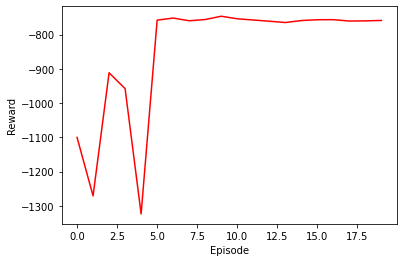

In [8]:
T = 4
dt = 0.001
time_list = np.linspace(0, T, int(T/dt))
target_list = np.sin(time_list * 2 * np.pi)
env = Plant(target = target_list, T = T, dt = dt)
agent = DDPGagent(env, tau = 1e-3, max_buffer_size =  2 ** 20, critic_lr = 1e-3, actor_lr = 1e-4)

max_episodes = 20
batch_size = 128
rewards = []
avg_rewards = []
episode_rewards = []
t = trange(max_episodes)

for episode in t:
    observation = env.reset()
    episode_reward = 0
    step = 0
    terminated = False
    truncated = False

    while (not terminated) and (not truncated):
        action = agent.get_action(observation)
        action = agent.noise(action, step)
        observation_new, reward, terminated, truncated, _ = env.step(action) 
        len_buffer = agent.add_buffer(observation, action, reward, observation_new, terminated)
        
        if len_buffer > batch_size:
            agent.update()      
        
        observation = observation_new
        episode_reward += reward

        if terminated or truncated:
            print("Episode " + str(episode) + ": " , np.round(episode_reward, decimals=2))  
            break

        t.set_postfix(reward = reward,  timesteps = step, totalreward = episode_reward)

        step += 1

    rewards.append(episode_reward)

plt.figure()
plt.plot(rewards, color = 'r')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

Text(0, 0.5, 'e')

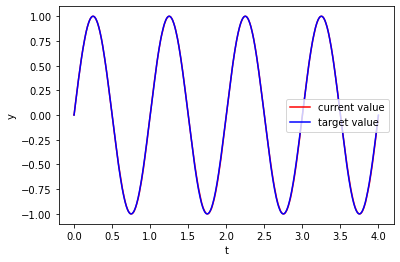

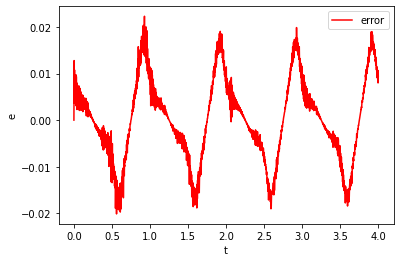

In [9]:
plt.figure()    
plt.plot(time_list[0:4000], env.current_value_sum, label = 'current value', color = 'r')
plt.plot(time_list, target_list, label = 'target value', color = 'b')
plt.legend()
plt.xlabel('t')
plt.ylabel('y')

plt.figure()    
plt.plot(time_list[0:4000], env.error_sum, label = 'error', color = 'r')
plt.legend()
plt.xlabel('t')
plt.ylabel('e')

Text(0, 0.5, 'e')

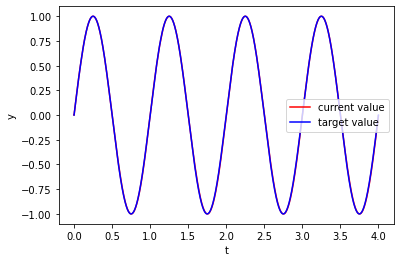

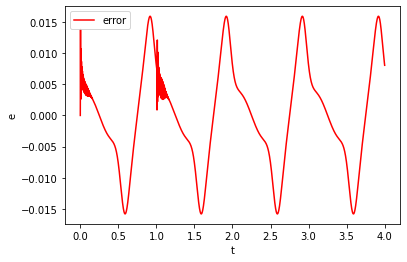

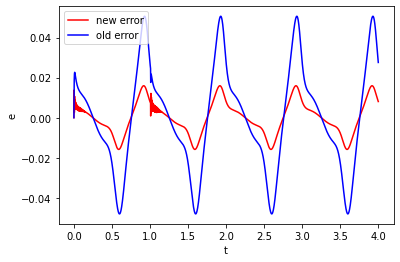

In [10]:
state_test = env.reset()
episode_reward_test = 0
terminated = False
truncated = False
while (not terminated) and (not truncated):     
    action_test = agent.get_action(state_test) 
    next_state_test, reward_test, terminated, truncated, _ = env.step(action_test)
    episode_reward_test += reward_test         
    state_test = next_state_test


plt.figure()    
plt.plot(time_list, env.current_value_sum, label = 'current value', color = 'r')
plt.plot(time_list, target_list, label = 'target value', color = 'b')
plt.legend()
plt.xlabel('t')
plt.ylabel('y')

plt.figure()    
plt.plot(time_list, env.error_sum, label = 'error', color = 'r')
plt.legend()
plt.xlabel('t')
plt.ylabel('e')

T = 4
dt = 0.001
time_list = np.linspace(0, T, int(T/dt))
target_list = np.sin(time_list * 2 * np.pi)
test = Plant(target = target_list, T = T, dt = dt)

for target in target_list:
    action = np.array([0.12,0.32,0.08])
    state, reward, terminated, truncated, _ = test.step(action)

plt.figure()    
plt.plot(time_list, env.error_sum, label = 'new error', color = 'r')
plt.plot(time_list, test.error_sum, label = 'old error', color = 'b')
plt.legend()
plt.xlabel('t')
plt.ylabel('e')

In [12]:
np.save('current_value_sum.npy', env.current_value_sum)
np.save('target_list.npy', target_list)
np.save('time_list.npy', time_list)
np.save('error_sum_env.npy', env.error_sum)
np.save('error_sum_test.npy', test.error_sum)

Text(0, 0.5, 'e')

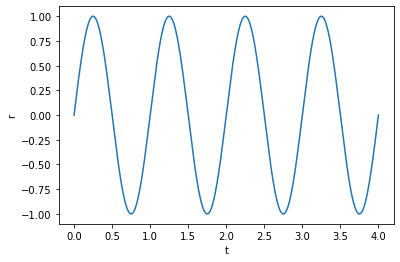

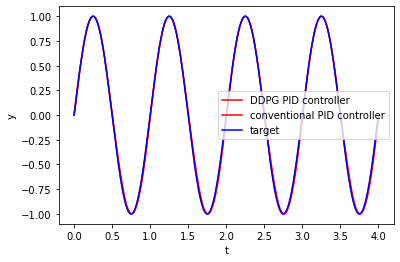

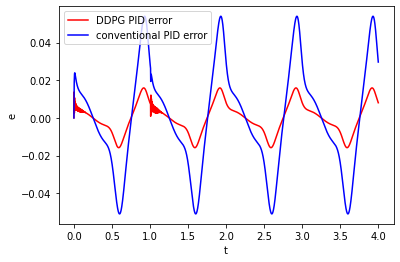

In [33]:
T = 4
dt = 0.001
time_list = np.linspace(0, T, int(T/dt))
target_list = np.sin(time_list * 2 * np.pi)
value = np.load('current_value_sum.npy')
er = np.load('error_sum_env.npy')
plt.figure()    
plt.plot(time_list, target_list)
plt.xlabel('t')
plt.ylabel('r')
plt.figure()    
plt.plot(time_list, value, label = 'DDPG PID controller', color = 'r')
plt.plot(time_list, test.current_value_sum, label = 'conventional PID controller', color = 'r')
plt.plot(time_list, target_list, label = 'target', color = 'b')
plt.legend()
plt.xlabel('t')
plt.ylabel('y')
plt.figure()    
plt.plot(time_list, er, label = 'DDPG PID error', color = 'r')
plt.plot(time_list, test.error_sum, label = 'conventional PID error', color = 'b')
plt.legend()
plt.xlabel('t')
plt.ylabel('e')